### 2. Grouping customers together!

In [2]:
import pandas as pd

import seaborn as sns

import numpy as np

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt


import statistics

import datetime

from sklearn import preprocessing

from pyensae.graphhelper import Corrplot

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer

import scipy.stats

from sklearn import preprocessing

from sklearn.cluster import AgglomerativeClustering



### 2.1 Getting your data + feature engineering

In [14]:
#Define an empty dataframe
Features = pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)

#Number of transaction
Features["Num_of_Transaction"] = bt[["CustomerID","TransactionID"]].groupby("CustomerID").count()

#Transaction with balance > 100:
Features["Balance>100_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").apply(lambda x: (x>100).sum())


#Average Amount of the transactions:
Features["Average_Amount"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(Average_Amount=("TransactionAmount (INR)",np.mean))


#Average Balance:
Features["Average_Balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.mean))


#Utilisation = Average difference between the balance and the transaction amount:
pd.options.mode.chained_assignment = None      #Avoid the red banner
bt["Utilisation"] = bt["CustAccountBalance"]-bt["TransactionAmount (INR)"]  #create "Utilisation" column
Features["Utilisation"] = bt[["CustomerID","Utilisation"]].groupby("CustomerID").agg(Utilisation=("Utilisation",np.mean))  #calculate the mean  

#Mode od Gender of the customer:  
Features["gender"]=bt[["CustomerID","CustGender"]].groupby("CustomerID").agg(CustGender =("CustGender",statistics.mode))

#Most frequent location of the customer
Features["Most_Frequent_Location"] = bt[["CustomerID","CustLocation"]].groupby("CustomerID").agg(CustLocation =("CustLocation",statistics.mode))


### Adding 20 additional features

* 1 Customer age (median of the age per customer)
* 2 Maximum transaction of the customer
* 3 Minimun transaction of the customer
* 4 Important customer (Define as Average_Balance greater than 80% of the average balance of all customers
* 5 Number of Teen agers :  teen ager (Define  20 years before the last transaction registered )
* 6 Class Age ( young <= 25 ; 26 < grown-up <= 60  ; elderly > 60 )
* 7 Transaction with balance < 80:
* 8 Date of birth of the first costumer
* 9 Maximum Balance : the maximum balance value that a custumer has
* 10 Minimum Balance : the minimum balance value that a custumer has
* 11 Average transaction
* 12 Number of man
* 13 Number of woman
* 14 Place of last transaction
* 15 PLace of the first transaction
* 16 Number_transaction>median : number of transaction greter than the median of transactions
* 17 Date_last: Date of the last transaction
* 18 Transaction_st_dev : Standard deviation of the transactions of the cosumer
* 19 Number_transaction>q3 : Number of transaction grater than third quartile
* 20 Transaction_CV : Coefficient of varation of the transaction of the custumer

In [16]:
# 1)
Features["Costumer_age"] = bt[["CustomerID","CustomerAge"]].groupby("CustomerID").median()

# 2)
Features["Max_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").max()

# 3)
Features["Min_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").min()

# 4)
Features["Important_costumer"] = Features["Average_Balance"] > Features["Average_Balance"].quantile(.8)

# 5)
# First  set the date after that people born are teen ager 
d1 = datetime.datetime(max(bt.TransactionDate).year - 20 ,max(bt.TransactionDate).month , max(bt.TransactionDate).day)
bt['teen'] = bt.CustomerDOB > d1
# Create the variables
Features["Number_of_teenager"] = bt[["CustomerID","teen"]].groupby("CustomerID").agg(teen =("teen", sum )) 

# 6)
# Here  we  copy the variable age
Features["Class_Age"]  = Features["Costumer_age"]

# Set a single age age
Features.Class_Age[ Features["Class_Age"] <= 25]  = 0

Features.Class_Age[ (Features["Class_Age"] > 25) &  (Features["Class_Age"] <= 60) ]   = 1

Features.Class_Age[ Features["Class_Age"] > 60 ]  = 2


# 7)
Features["Balance<80_USD"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID")["CustAccountBalance"].apply(lambda x: (x<80).sum())

# 8)
Features["Date_of_birth"] = bt[["CustomerID","CustomerDOB"]].groupby("CustomerID").first()

# 9)
Features["Maximum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.max))

# 10)
Features["Minimum_balance"] = bt[["CustomerID","CustAccountBalance"]].groupby("CustomerID").agg(Average_Balance=("CustAccountBalance",np.min))

# 11)
Features["Median_transaction"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").median()

# 12)
Features["Number_of_woman"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "F").sum())

# 13)
Features["Number_of_man"] = bt[["CustomerID","CustGender", "TransactionAmount (INR)" ]].groupby("CustomerID")["CustGender"].apply(lambda x: (x == "M").sum())

# 14) 

Features["Place_last"] = bt[["TransactionDate","CustomerID","CustLocation"]].sort_values(by="TransactionDate").groupby("CustomerID")["CustLocation"].last()

# 15)
Features["Place_first"] = bt[["TransactionDate","CustomerID","CustLocation"]].sort_values(by="TransactionDate").groupby("CustomerID")["CustLocation"].first()

# 16)
m = bt["TransactionAmount (INR)"].median()
Features["Number_transaction>median"] = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").apply( lambda x : (x>m).sum()  )

# 17)
Features["Date_last"] = bt[["TransactionDate","CustomerID"]].sort_values(by="TransactionDate").groupby("CustomerID").last()

# 18)
deviance = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").std()
deviance.fillna(value=0 , inplace = True )
Features["Transaction_st_dev"] = deviance

# 19)
q = bt["TransactionAmount (INR)"].quantile(.75)
Features["Number_transaction>q3"] = bt[["TransactionAmount (INR)" ,"CustomerID" ]].groupby("CustomerID").apply( lambda x : (x>q).sum()  )

# 20)
Features["Transaction_CV"] = bt[["CustomerID","TransactionAmount (INR)"]].groupby("CustomerID").agg(CustGender =("TransactionAmount (INR)", scipy.stats.variation ))


/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1021: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis, ddof=ddof) / a.mean(axis)


In [17]:
#save
Features.to_pickle("Custumer.pkl")

In [5]:
#load
Custumer = pd.read_pickle("Custumer.pkl")

## 2.2 Choose your features (variables)!


Principal component analysis (PCA) allows us to summarize and to visualize the information in a data set containing individuals/observations described by multiple inter-correlated quantitative variables. Each variable could be considered as a different dimension. If we have more than 3 variables in your data sets, it could be very difficult to visualize a multidimensional hyperspace.


Principal component analysis is used to extract the important information from a multivariate  data table and to express this information as a set of few new variables called principal components. These new variables correspond to a linear combination of the originals. The number of principal components is less than or equal to the number of original variables.


The information in a given data set corresponds to the total variation it contains. The goal of PCA is to identify directions (or principal components) along which the variation in the data is maximal.

 In other words, PCA reduces the dimensionality of a multivariate quantitative dataset to a fewer number of  principal components, that can be visualized graphically, with minimal loss of information.



In order to perform the PCA analysis we need to standardize the data because PCA associate Variance with information, colliding variables into Principal components that explain a percentage of the variance / information of our data.

In our case we have variables as Number of transaction supported around (1,..,6) and others as Utilisation that can assume really huge values in comparison.

Variance, being a not a normalized statistic , don't allow us to compare itself between others variable.

Then, in conclusion, we are going to normalize the data and compute the PCA.

In [6]:
# SELECT ONLY THE QUANTITATIVE VARIABLES
columns = [ "Num_of_Transaction" , "Balance>100_USD"   , "Average_Amount" ,
            "Costumer_age"  , "Average_Balance" , "Utilisation" , "Maximum_balance" ,
            "Minimum_balance" , "Median_transaction" , "Number_of_woman" ,  "Number_of_man",
            "Number_of_teenager" , "Balance<80_USD"  , "Minimum_balance"  , 
            "Number_transaction>median" , "Number_transaction>q3"  ]

In [7]:
data_red = Custumer[columns] 

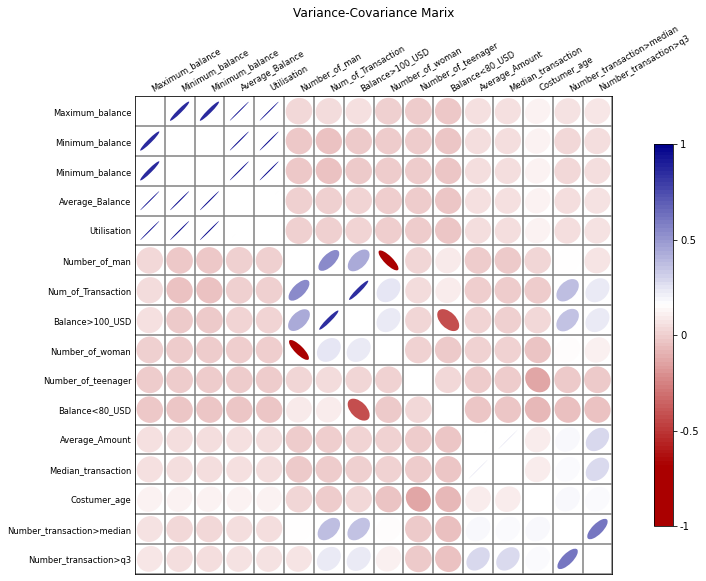

In [12]:
c = Corrplot(data_red)
c.plot(figsize=(12,8))
plt.title("Variance-Covariance Marix")
plt.show()



In [13]:
x = data_red.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_red = pd.DataFrame(x_scaled)

In [18]:
pca = PCA(n_components=13)
pca_features = pca.fit_transform(data_red)
 
print('Shape before PCA: ', data_red.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (839081, 16)
Shape after PCA:  (839081, 13)


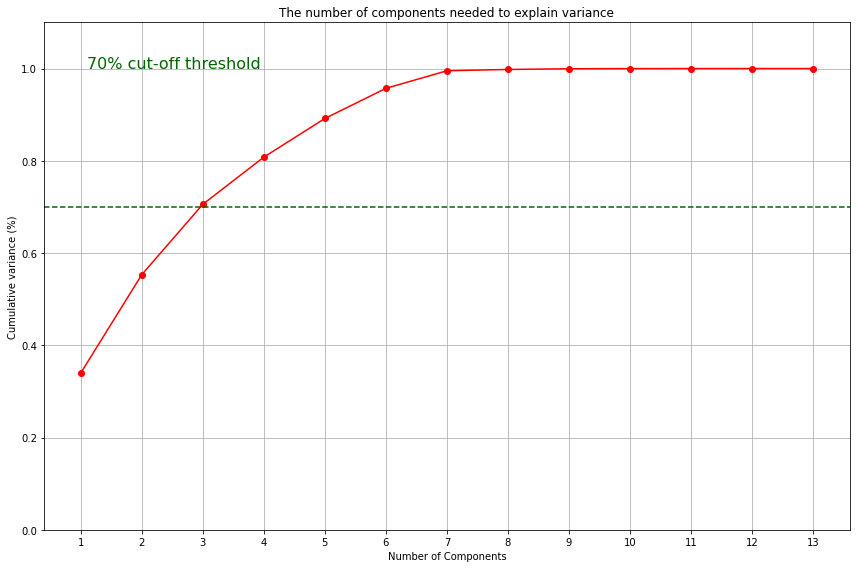

In [22]:
plt.rcParams["figure.figsize"] = (12,8)

fig, ax = plt.subplots()
xi = np.arange(1, 14, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='red')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 14, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.7, color='darkgreen', linestyle='--')
plt.text(1.1, 1, '70% cut-off threshold', color = 'darkgreen', fontsize=16)

ax.grid()
plt.tight_layout()
plt.show()

## Comments:
Plots shown tha we need to use at least 3 Principal components in order to have at least 70% of the variance

In [23]:
pca = PCA(n_components =  3)
pca_features = pca.fit_transform(data_red)


# 2.3 Clustering!

In [26]:
model = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='single')

In [ ]:
age_balance_sample['cluster'] = model.fit_predict()

In [159]:
age_balance_sample = data_red
age_balance_sample = age_balance_sample.sample(2000)

/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


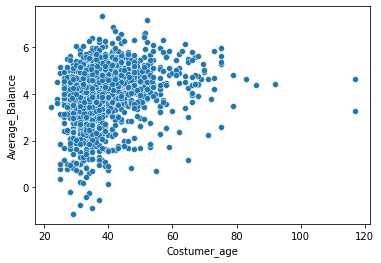

In [160]:
sns.scatterplot(x = age_balance_sample.Costumer_age, y = np.log10(age_balance_sample.Average_Balance));

In [161]:
model.fit_predict(age_balance_sample)
age_balance_sample['cluster'] = model.fit_predict(age_balance_sample)

In [46]:
model = KMeans(n_clusters= 4)


In [173]:
age_balance_sample['cluster'] = model.fit_predict(age_balance_sample)

/Users/paolo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


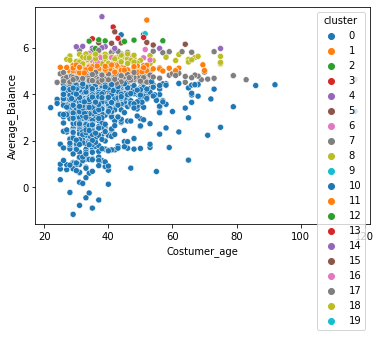

In [174]:
sns.scatterplot(x = age_balance_sample.Costumer_age,
                 y = np.log10(age_balance_sample.Average_Balance),
                 palette = "tab10" ,
                  hue=age_balance_sample.cluster);

In [171]:
sd = {}
for k in range(10, 100):
    model = KMeans(n_clusters=k)
    model.fit(age_balance_sample)
    sd[k] = model.inertia_

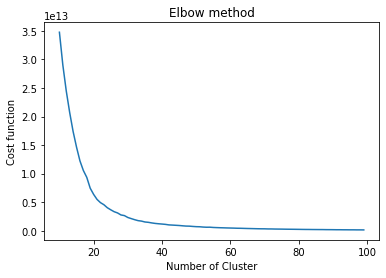

In [172]:
plt.figure()
plt.plot(list(sd.keys()), list(sd.values()))
plt.xlabel('Number of Cluster')
plt.ylabel('Cost function')
plt.title('Elbow method')
plt.show()

## KMEANS


In [ ]:
# 1) Normalize the data: gia normalizzati per la PCA
data_red 

In [ ]:
#1)Essendo un k-means semplice si parte da un centroide randomizzato:
centroide = data_red.apply(lambda x: float(x.sample()))  #tramite sample seleziono valori random dalle colonne, mi prendo solo i float

In [ ]:
#2)dopo aver calcolato il numero di cluster k ideale, calcolo un centroide per ogni k:
centroidi = []  #inizializzo lista dei centroidi
k= 3  #esempio
for i in range(1,k+1):
    centroide = data_red.apply(lambda x: float(x.sample()))     #prendo un sample random da righe e colonne(il mio centroide)
    centroidi.append(centroide)

In [ ]:
#3) Calcolo distanza rispetto del dato rispetto ad ogni centroide(devo trasformare prima i centroidi in un df):
centroidi = pd.concat(centroidi,axis=1)
distanza = centroidi.apply(lambda x: np.sqrt(((data_red-x) ** 2).sum(axis=1)))
#Ottengo un dataframe con la distanza(per ogni riga) del dato rispetto al centroide(uno per cluster)

In [ ]:
#4)Devo calcolare la distanza minima per ogni valore, cioè trovare i valori piu vicini ad ogni cluster:
distanzamin = distanza.idxmin(axis=1)

In [ ]:
#5)aggiorno centroide con le distanze minime:
data_red.groupby(distanzamin).apply(lambda x: np.exp(np.log(x).mean())).T

In [ ]:
#Vanno infine iterati i passi 3-4-5 finche non ho convergenza:
n = 1
nmax = 10
centroidi = []  #inizializzo lista dei centroidi
k= 3  #esempio
for i in range(1,k+1):
    centroide = data_red.apply(lambda x: float(x.sample()))    
    centroidi.append(centroide)
centroidi = pd.concat(centroidi,axis=1)

old_centroids = pd.DataFrame()    

In [ ]:
import numpy as np
np.seterr(divide = 'ignore') 

while n < nmax and not centroidi.equals(old_centroids):
    old_centroids = centroidi
    centroidi.apply(lambda x: np.sqrt(((data_red-x) ** 2).sum(axis=1))).idxmin(axis=1)
    x =centroidi.apply(lambda x: np.sqrt(((data_red-x) ** 2).sum(axis=1))).idxmin(axis=1)     #passo 3 e 4
    centroidi = data_red.groupby(x).apply(lambda x: np.exp(np.log(x).mean())).T                            #passo 5
print(centroidi)
    

In [ ]:
#confronto con kmeans normale(non ++)
from sklearn.cluster import KMeans_plusplus
kmeans = KMeans(3)
kmeans.fit(data_red)
centroids= kmeans.cluster_centers_
pd.DataFrame(centroids,columns=columns).T


## 2.4 Analysing your results!

2.4.1) Select the relevant variables

In [148]:
relevant = [ "gender", "Important_costumer" , "Average_Amount" , "Num_of_Transaction" ]

2.4.2) Categories the continuos variable into 4 catagories.

In [165]:
data = Custumer[relevant]

q25 = data.Average_Amount.quantile(.33)
q50 = data.Average_Amount.quantile(.66)
q75 = data.Average_Amount.quantile(.75)



data.Average_Amount[data.Average_Amount < q25] = 1
data.Average_Amount[(data.Average_Amount > q25) & (data.Average_Amount < q50)] = 2
data.Average_Amount[(data.Average_Amount > q50) & (data.Average_Amount < q75 )] = 3
data.Average_Amount[data.Average_Amount > q75] = 4


data.Num_of_Transaction[data.Num_of_Transaction <= 2] = 1
data.Num_of_Transaction[(data.Num_of_Transaction > 2) &  (data.Num_of_Transaction <= 4) ] = 2
data.Num_of_Transaction[data.Num_of_Transaction == 5] = 3
data.Num_of_Transaction[data.Num_of_Transaction == 6] = 4


2.4.3) 
Perform the pivot table

First we define the cluster based on K-Means method , we select the number of cluster k equal to 4. And we compute the distance using the 2 pca in order to don't have computationally expensive operations.

In [166]:
model = KMeans(n_clusters= 4)
pca = PCA(n_components=2)
pca_to_clusterize = pca.fit_transform(Custumer[columns])
df =  pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False) # Define an empty data frame
df["cluster"] = model.fit_predict(pca_to_clusterize)                            # Populate the dataframe according to the cluster

In [167]:
df["Gender"] = data["gender"].values                                        # Add Gender values
df["Important_custumer"] = data["Important_costumer"].values                # Add Important custumer values
df["Number_of_Transaction"] = data["Num_of_Transaction"].values
df["Average_amount"] = data["Average_Amount"].values

Now we build a pivot data set we will populate with the pivot - table.

In [168]:
pivot =  pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)  

In [169]:
pivot["Female"] = df.groupby("cluster")["Gender"].apply( lambda x : (x =="F").sum() / ( ( x == "F").sum() +  ( x == "M").sum() ) * 100 )
pivot["Male"]   = df.groupby("cluster")["Gender"].apply( lambda x : (x =="M").sum() / ( ( x == "F").sum() +  ( x == "M").sum() ) * 100 )

In [171]:
pivot["Important_custumer"]       = df.groupby("cluster")["Important_custumer"].apply( lambda x : (x == True).sum() / ( ( x == False).sum() +  ( x == True).sum() ) * 100 )
pivot["NOT_Important_custumer"]   = df.groupby("cluster")["Important_custumer"].apply( lambda x : (x == False).sum() / ( ( x == False).sum() +  ( x == True).sum() ) * 100 )

In [176]:
pivot["Poor"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 1).sum() / x.count() * 100 )
pivot["Middle_one"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 2).sum() / x.count() * 100 )
pivot["Middle_two"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 3).sum() / x.count() * 100 )
pivot["Rich"] = df.groupby("cluster")["Average_amount"].apply( lambda x : (x == 4).sum() / x.count() * 100 )

In [179]:
pivot["Few_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 1).sum() / x.count() * 100 )
pivot["Some_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 2).sum() / x.count() * 100 )
pivot["Many_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 3).sum() / x.count() * 100 )
pivot["A_lot_of_transaction"] = df.groupby("cluster")["Number_of_Transaction"].apply( lambda x : (x == 4).sum() / x.count() * 100 )

In [180]:
pivot[["Male","Female"]]

,Male,Female
cluster,,
0,80.787217,19.212783
1,72.404482,27.595518
2,42.307692,57.692308
3,86.267606,13.732394


In [181]:
pivot[["Important_custumer","NOT_Important_custumer"]]

,Important_custumer,NOT_Important_custumer
cluster,,
0,100.000000,0.000000
1,19.476416,80.523584
2,100.000000,0.000000
3,100.000000,0.000000


In [182]:
pivot[["Poor","Middle_one","Middle_two","Rich"]]

,Poor,Middle_one,Middle_two,Rich
cluster,,,,
0,13.971161,20.362432,9.547935,56.079501
1,33.057355,33.034563,8.970790,24.792146
2,0.000000,0.000000,0.000000,100.000000
3,16.549296,12.323944,4.929577,66.197183


In [183]:
pivot[["Few_transaction","Some_transaction","Many_transaction","A_lot_of_transaction"]]

,Few_transaction,Some_transaction,Many_transaction,A_lot_of_transaction
cluster,,,,
0,98.460639,1.519875,0.019486,0.00000
1,98.119810,1.866635,0.012835,0.00072
2,100.000000,0.000000,0.000000,0.00000
3,98.239437,1.760563,0.000000,0.00000
